<a href="https://colab.research.google.com/github/JonathanCristovao/LSTM_GRU_RNN_human-activity-recognition/blob/main/LSTM_GRU_RNN_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook was run on google colab

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [10]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
import glob
import csv
import os
%matplotlib inline
from keras_self_attention import SeqSelfAttention
import warnings
warnings.filterwarnings('ignore')

## The dataset used in this notebook can be downloaded here:
[Click here to download the Dataset](https://www.kaggle.com/datasets/jonathansilva2020/dataset-for-human-activity-recognition-har)



In [12]:
interesting_dir = "/content/drive/MyDrive/dataset_artigo_sensores_new"
interesting_labels = ['seated','stand','walk','iw_uphill']
save_filename = "activity"

## Concate and label the raw data  

In [13]:
def data_concate_label(path,label):
    all_files1 = glob.glob(path + "/*.csv")
    
    li = []

    for filename in all_files1:
        df = pd.read_csv(filename, index_col=None, header=0)
        
        if 'label' in df.columns:
            pass
        else:df['label'] = str(label)
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    if len(df.columns) == 8 :
        new_header =['date','time','ID_S','Q_I','Q_J','Q_K','Q_R','label']
    
    else :
       
        new_header =['date','time','ID_S','Q_I','Q_J','Q_K','Q_R','label']

    frame = frame[:16000]
    
    print(frame.shape)
    print(len(df.columns))
    frame.to_csv("/content/drive/MyDrive/data/novo_"+str(label)+".csv",index = False,header=new_header)
    

In [14]:
path1 = "/content/drive/MyDrive/dataset_artigo_sensores_new/seated"
label1 = "seated"
path2 = "/content/drive/MyDrive/dataset_artigo_sensores_new/stand"
label2 = "stand"
path3 = "/content/drive/MyDrive/dataset_artigo_sensores_new/walking"
label3 = "walk"
path4 = "/content/drive/MyDrive/dataset_artigo_sensores_new/iwuphill"
label4 = "iw_uphill"
data_concate_label(path1,label1)
data_concate_label(path2,label2)
data_concate_label(path3,label3)
data_concate_label(path4,label4)

(7267, 8)
8
(6110, 8)
8
(4980, 8)
8
(2656, 8)
8


## Concate all data into one .csv file

In [15]:
import copy

df = pd.DataFrame()
for i in range(len(interesting_labels)):
    df_tmp = pd.read_csv(interesting_dir+"/"+save_filename+"_"+interesting_labels[i]+'.csv',header = 0)
    df = pd.concat([df, df_tmp])
print(len(df.columns))

drop_list = ['date','time']

df = df.drop(drop_list, axis=1)
df = df.dropna()

all_data_filename = "total.csv"
df.to_csv(interesting_dir+all_data_filename)

df.head()

8


,ID_S,Q_I,Q_J,Q_K,Q_R,label
0,2,0.09,0.02,0.79,0.61,seated
1,4,0.02,-0.04,0.73,0.68,seated
2,1,0.27,0.58,-0.09,0.77,seated
3,3,0.29,0.53,-0.44,0.66,seated
4,2,0.09,0.02,0.79,0.61,seated


## Feature correlation 

In [16]:
df_cor = copy.deepcopy(df) 

features = df_cor.columns[0:-1]
df_cor["label"] = pd.factorize(df_cor.label)[0]
traindf = pd.DataFrame(df_cor,columns=features)

feature_name = list(traindf.columns)
print(feature_name)
y = df_cor['label']
X = traindf.copy()
X.isna().sum()

['ID_S', 'Q_I', 'Q_J', 'Q_K', 'Q_R']


ID_S    0
Q_I     0
Q_J     0
Q_K     0
Q_R     0
dtype: int64

[0.09465828 0.18073216 0.18703472 0.27013436 0.26744048]


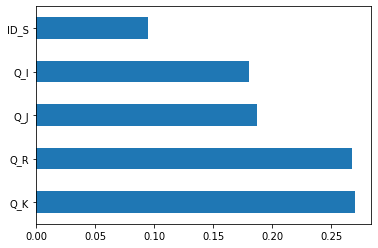

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
#get correlations of each features in dataset
#corrmat = df_cor.corr()
#top_corr_features = corrmat.index
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(df_cor[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [18]:
num_feats= len(feature_name)
X.columns.tolist()

['ID_S', 'Q_I', 'Q_J', 'Q_K', 'Q_R']

In [19]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
   
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    return cor_support, cor_feature, cor_list

cor_support, cor_feature, cor_list = cor_selector(X, y,num_feats)
cor_val=[abs(x) for x in cor_list]
cor_result = dict(zip(cor_feature, cor_val))
myDict = {key:val for key, val in cor_result.items() if val > 0}
{k: v for k, v in sorted(myDict.items(),reverse=True, key=lambda item: item[1])}

{'Q_R': 0.4239660579305199,
 'Q_K': 0.3969119027314007,
 'Q_J': 0.14835000752817498,
 'Q_I': 0.010849572101052486,
 'ID_S': 0.00046961609606380503}

In [20]:
activities = df['label'].value_counts().index
activities

Index(['seated', 'iw_uphill', 'stand', 'walk'], dtype='object')

## Split training and testing data

In [21]:
def train_test_split(label, ratio):
    split_point = int(len(df[df.label == label]) * ratio)
    return (df[df.label == label].iloc[:split_point, :], df[df.label == label].iloc[split_point:, :])

split_ratio = 0.8
train_data = pd.DataFrame([])
test_data = pd.DataFrame([])

for i in range(len(interesting_labels)):
    (train, test) = train_test_split(interesting_labels[i], split_ratio)
    train_data = pd.concat([train_data, train])
    test_data = pd.concat([test_data, test])

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))


train_label = train_data['label'].to_frame()
test_label = test_data['label'].to_frame()

Number of train samples:  2066
Number of test samples:  518


## Data Segmentation (Sliding Window)

In [22]:
N_TIME_STEPS = 10 #sliding window length 120
STEP = 2 # Sliding window step size 20
N_FEATURES = 5

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):

        ID_S = x['ID_S'].values[i: i + n_time_steps]
        Q_I = x['Q_I'].values[i: i + n_time_steps]
        Q_J = x['Q_J'].values[i: i + n_time_steps]
        Q_K = x['Q_K'].values[i: i + n_time_steps]
        Q_R = x['Q_R'].values[i: i + n_time_steps]
     
        label = stats.mode(y['label'][i: i + n_time_steps])[0][0]
        segments.append([ID_S, Q_I, Q_J, Q_K, Q_R])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_data, train_label, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_data, test_label, N_TIME_STEPS, STEP)

In [23]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [ ]:
#y_test

## Import DL Library

In [25]:
from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Flatten, Bidirectional
from tensorflow.keras.layers import Attention
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import optimizers
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
N_CLASSES = 4
L2 = 0.00001

## LSTM Model 

In [26]:
# LSTM model
from keras.backend import clear_session
filepath = 'har_model_lstm_2021.h5'

clear_session()
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True,kernel_initializer='orthogonal',
                             kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
                             bias_regularizer=l2(L2),name="LSTM_1"),
                             input_shape=(N_TIME_STEPS, N_FEATURES)))

model.add(Flatten(name='Flatten'))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_3"))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_4"))


model.summary()

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
reduce =  ReduceLROnPlateau(monitor='val_loss',
                    factor=0.5,
                    patience=2,
                    verbose=1)
callbacks = [checkpoint,stop]

model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

BATCH_SIZE =64
N_EPOCHS = 300

lstm = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, shuffle=True,epochs=N_EPOCHS,callbacks=callbacks,
          validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 400)          329600    
 l)                                                              
                                                                 
 Flatten (Flatten)           (None, 4000)              0         
                                                                 
 Dense_3 (Dense)             (None, 128)               512128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 842,244
Trainable params: 842,244
Non-trainable params: 0
__________________________________________________

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


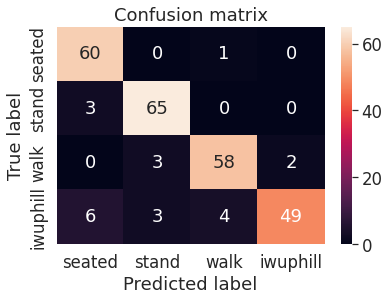

In [27]:
# use LSTM model to predict

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(y_true_labels)
LABELS = ['seated', 'stand','walk','iwuphill']

#plt.figure(figsize=(12, 12))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [28]:
predIdxs = model.predict(X_test, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

In [29]:
# show a classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
	target_names=['seated', 'stand','walk','iwuphill']))


              precision    recall  f1-score   support

      seated       0.87      0.98      0.92        61
       stand       0.92      0.96      0.94        68
        walk       0.92      0.92      0.92        63
    iwuphill       0.96      0.79      0.87        62

    accuracy                           0.91       254
   macro avg       0.92      0.91      0.91       254
weighted avg       0.92      0.91      0.91       254



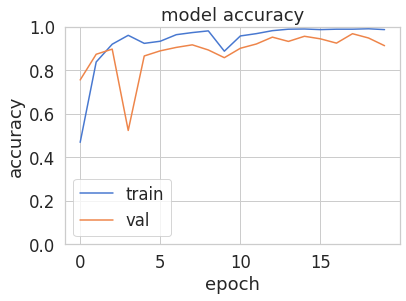

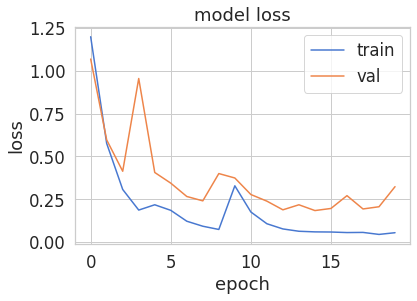

In [30]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

## Save the model into .pb file

In [ ]:
# Save LSTM model

output_node_name = "Dense_2/Softmax"
MODEL_LSTM = str(N_TIME_STEPS)+"_"+str(STEP)+"_"+str(N_FEATURES)+"_"+str(N_CLASSES)+"_nomagnew"

tf.train.write_graph(K.get_session().graph_def, './models/LSTM/', \
        MODEL_LSTM + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(K.get_session(), './models/LSTM/' + MODEL_LSTM + '.chkp')

freeze_graph.freeze_graph('./models/LSTM/' +MODEL_LSTM+ '_graph.pbtxt', None, \
    False, './models/LSTM/' + MODEL_LSTM+ '.chkp', output_node_name, \
    "save/restore_all", "save/Const:0", \
    './models/LSTM/' +MODEL_LSTM + '.pb', True, "")

# GRU Model

In [31]:
from keras.layers import GRU

In [32]:
# GRU model
from keras.backend import clear_session
filepath = 'har_model_gru.h5'

clear_session()
model = Sequential()
model.add(Bidirectional(GRU(200, return_sequences=True,kernel_initializer='orthogonal',
                             kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
                             bias_regularizer=l2(L2),name="LSTM_1"),
                             input_shape=(N_TIME_STEPS, N_FEATURES)))

model.add(Flatten(name='Flatten'))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_3"))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_4"))


model.summary()

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
reduce =  ReduceLROnPlateau(monitor='val_loss',
                    factor=0.5,
                    patience=2,
                    verbose=1)
callbacks = [checkpoint,stop]

model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

BATCH_SIZE =64
N_EPOCHS = 300

lstm = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, shuffle=True,epochs=N_EPOCHS,callbacks=callbacks,
          validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 400)          248400    
 l)                                                              
                                                                 
 Flatten (Flatten)           (None, 4000)              0         
                                                                 
 Dense_3 (Dense)             (None, 128)               512128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 761,044
Trainable params: 761,044
Non-trainable params: 0
__________________________________________________

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


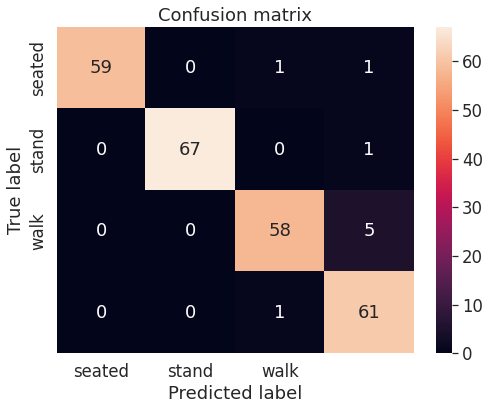

In [33]:
# GRU model to predict

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(y_true_labels)
LABELS = ['seated', 'stand','walk']

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();



In [35]:
predIdxs = model.predict(X_test, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

# show a classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
	target_names=['seated', 'stand','walk','iwuphill']))




              precision    recall  f1-score   support

      seated       1.00      0.97      0.98        61
       stand       1.00      0.99      0.99        68
        walk       0.97      0.92      0.94        63
    iwuphill       0.90      0.98      0.94        62

    accuracy                           0.96       254
   macro avg       0.97      0.96      0.96       254
weighted avg       0.97      0.96      0.96       254



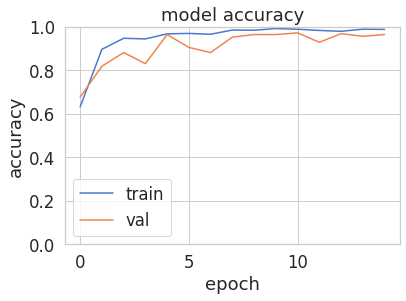

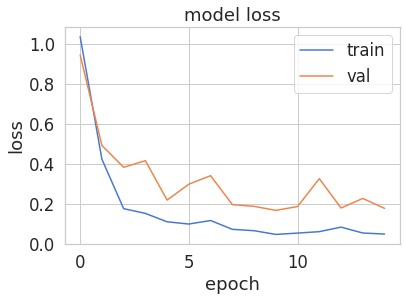

In [36]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()



RNN Model

In [43]:
from keras.layers import SimpleRNN

In [47]:
# Simple RNN model
from keras.backend import clear_session
filepath = 'har_model_rnn.h5'

clear_session()
model = Sequential()

model.add(SimpleRNN(200,input_shape=(N_TIME_STEPS, N_FEATURES), return_sequences=True,kernel_initializer='orthogonal',
                             kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
                             bias_regularizer=l2(L2),))


model.add(Flatten(name='Flatten'))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_3"))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_4"))


model.summary()

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
reduce =  ReduceLROnPlateau(monitor='val_loss',
                    factor=0.5,
                    patience=2,
                    verbose=1)
callbacks = [checkpoint,stop]

model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

BATCH_SIZE =64
N_EPOCHS = 300

lstm = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, shuffle=True,epochs=N_EPOCHS,callbacks=callbacks,
          validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 200)           41200     
                                                                 
 Flatten (Flatten)           (None, 2000)              0         
                                                                 
 Dense_3 (Dense)             (None, 128)               256128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 297,844
Trainable params: 297,844
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
17/17 [==============================]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


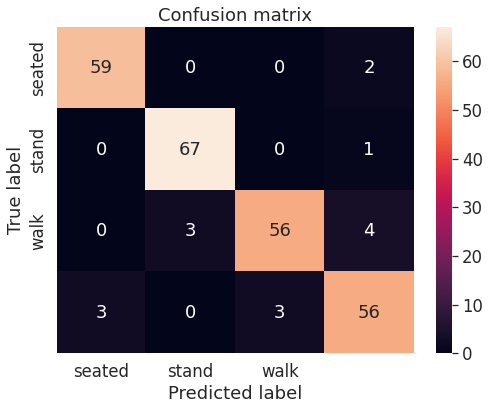

In [48]:
# RNN model to predict

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(y_true_labels)
LABELS = ['seated', 'stand','walk']

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();


In [50]:
predIdxs = model.predict(X_test, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

# show a classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
	target_names=['seated', 'stand','walk','iwuphill']))

              precision    recall  f1-score   support

      seated       0.95      0.97      0.96        61
       stand       0.96      0.99      0.97        68
        walk       0.95      0.89      0.92        63
    iwuphill       0.89      0.90      0.90        62

    accuracy                           0.94       254
   macro avg       0.94      0.94      0.94       254
weighted avg       0.94      0.94      0.94       254



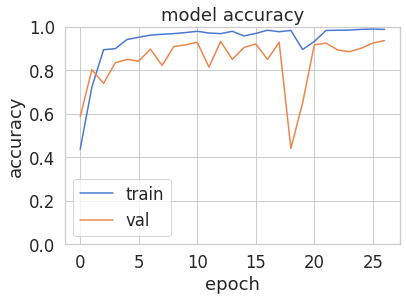

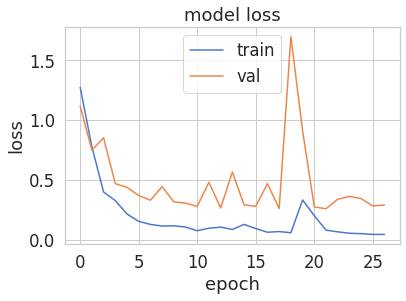

In [49]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

